In [38]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sets = pd.read_csv("X023_set_export.csv")

In [39]:
columns_of_interest = [
    "set_number", "start_date", "end_date", 'start_latitude_DD',
    'start_latitude_MMmm', 'start_longitude_DD', 'start_longitude_MMmm', 'end_latitude_DD',
    'end_latitude_MMmm', 'end_longitude_DD', 'end_longitude_MMmm', "set_result"
]
sets[columns_of_interest].head()


,set_number,start_date,end_date,start_latitude_DD,start_latitude_MMmm,start_longitude_DD,start_longitude_MMmm,end_latitude_DD,end_latitude_MMmm,end_longitude_DD,end_longitude_MMmm,set_result
0,1,2023-06-20 14:48:42 UTC,2023-06-21 09:23:20 UTC,46,NaN,-64,NaN,46.0,NaN,-64.0,NaN,1 - NORMAL - No damage to gear
1,2,2023-06-20 14:55:00 UTC,2023-06-21 09:41:42 UTC,46,NaN,-64,NaN,46.0,NaN,-64.0,NaN,1 - NORMAL - No damage to gear
2,3,2023-06-20 15:00:54 UTC,2023-06-21 09:51:54 UTC,46,49.39991,-64,18.45374,46.0,49.40960,-64.0,18.40501,1 - NORMAL - No damage to gear
3,4,2023-06-20 15:08:17 UTC,2023-06-21 10:00:29 UTC,46,NaN,-64,NaN,46.0,NaN,-64.0,NaN,1 - NORMAL - No damage to gear
4,5,2023-06-20 15:14:13 UTC,2023-06-21 10:11:03 UTC,46,46.83280,-64,22.06068,46.0,46.85389,-64.0,22.02738,1 - NORMAL - No damage to gear


### There seems to be a few sets with missing coordinates

In [43]:
bmask = (sets["start_latitude_MMmm"].isnull()) | (sets["start_longitude_MMmm"].isnull()) | (sets["start_latitude_DD"] == 0)
sets.loc[bmask, "set_number"]


0        1
1        2
3        4
90      91
452    453
801    802
Name: set_number, dtype: int64

Set numbers 1, 2, 4, 91, 453, and 802 are all missing coordinates. 

We'll have to set these sets aside for now

In [45]:
sets = sets[bmask==False]

# define a function for producing decimal degrees
def coord_combiner(d, m, longitude=False):
    # always dealing with positive number
    if d < 0:
        d = -d

    if m < 0:
        m = -m

    # perform the calculations and return
    my_coord = float(d) + float(m) / 60
    if longitude:
        return -my_coord
    else:
        return my_coord


# clean up the dataframe
## convert DDMM to dec deg
sets["start_latitude"] = sets.apply(lambda x: coord_combiner(x["start_latitude_DD"], x["start_latitude_MMmm"], False), axis=1)
sets["start_longitude"] = sets.apply(lambda x: coord_combiner(x["start_longitude_DD"], x["start_longitude_MMmm"], False), axis=1)
sets["end_latitude"] = sets.apply(lambda x: coord_combiner(x["end_latitude_DD"], x["end_latitude_MMmm"], False), axis=1)
sets["end_longitude"] = sets.apply(lambda x: coord_combiner(x["end_longitude_DD"], x["end_longitude_MMmm"], False), axis=1)
## datetime string to datetime objects
sets["start_date"] = pd.to_datetime(sets["start_date"])
sets["end_date"] = pd.to_datetime(sets["end_date"])


In [46]:
columns_of_interest = ["set_number", "start_date", "end_date", 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']
sets = sets[columns_of_interest]
sets

,set_number,start_date,end_date,start_latitude,start_longitude,end_latitude,end_longitude
2,3,2023-06-20 15:00:54+00:00,2023-06-21 09:51:54+00:00,46.823332,64.307562,46.823493,64.306750
4,5,2023-06-20 15:14:13+00:00,2023-06-21 10:11:03+00:00,46.780547,64.367678,46.780898,64.367123
5,6,2023-06-20 15:20:59+00:00,2023-06-21 10:20:12+00:00,46.758868,64.399047,46.758929,64.398871
6,7,2023-06-20 15:27:58+00:00,2023-06-21 10:30:00+00:00,46.780963,64.428189,46.780732,64.427928
7,8,2023-06-20 15:35:09+00:00,2023-06-21 10:38:36+00:00,46.800959,64.399178,46.801332,64.398965
...,...,...,...,...,...,...,...
839,840,2023-08-03 18:42:21+00:00,2023-08-04 16:22:02+00:00,47.986985,65.849799,47.987216,65.849069
840,841,2023-08-03 18:59:04+00:00,2023-08-04 16:38:45+00:00,48.008850,65.822309,48.007776,65.820893
841,842,2023-08-03 19:09:51+00:00,2023-08-04 16:46:45+00:00,47.987321,65.787154,47.987620,65.786459
842,843,2023-08-03 19:18:56+00:00,2023-08-04 16:57:09+00:00,47.967994,65.753419,47.968229,65.752661


In [47]:
# it would be interesting to look at the set distances

def calc_nautical_dist(p0, p1):
    """
    p0 and p1 should be dicts with key 'lat' and 'lng'
    """
    try:
        nautical_miles = 3443.8985 * math.acos(
            math.sin(p0["lat"] * math.pi / 180) * math.sin(p1["lat"] * math.pi / 180) +
            math.cos(p0["lat"] * math.pi / 180) * math.cos(p1["lat"] * math.pi / 180) *
            math.cos(p1["lng"] * math.pi / 180 - p0["lng"] * math.pi / 180)
        )
        return nautical_miles
    except:
        pass


sets["distance"] = sets.apply(
    lambda x: calc_nautical_dist({"lat": x["start_latitude"], "lng": x["start_longitude"]}, {"lat": x["end_latitude"], "lng": x["end_longitude"]}), axis=1)



Text(0, 0.5, 'Distance (nm)')

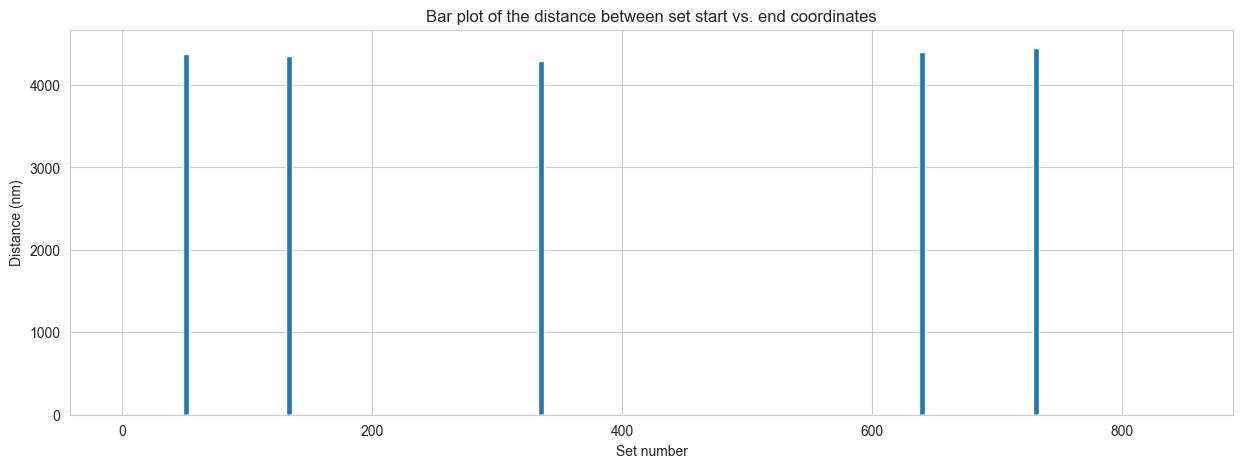

In [48]:
plt.figure(figsize=(15,5))
hist = np.histogram(sets["distance"].dropna())
plt.bar(sets["set_number"], sets["distance"], width=5)
plt.title("Bar plot of the distance between set start vs. end coordinates")
plt.xlabel("Set number")
plt.ylabel("Distance (nm)")

In the above, we can see there are some that have huge distances. 

In [49]:
# let's get a list of sets whose distances are greater than 10

mask = sets["distance"] > 10
sets[mask]




,set_number,start_date,end_date,start_latitude,start_longitude,end_latitude,end_longitude,distance
50,51,2023-06-21 11:31:38+00:00,2023-06-22 11:25:02+00:00,46.884397,64.339347,0.0,0.0,4374.868048
132,133,2023-07-04 18:30:27+00:00,2023-07-05 13:31:51+00:00,46.637585,63.791706,0.0,0.0,4348.658763
334,335,2023-07-12 15:16:57+00:00,2023-07-13 13:58:33+00:00,45.873964,62.795817,0.0,0.0,4294.081024
639,640,2023-07-26 14:05:34+00:00,2023-07-27 13:57:56+00:00,47.525489,64.750857,0.0,0.0,4403.438970
730,731,2023-08-01 10:19:32+00:00,2023-08-02 10:19:18+00:00,47.885763,65.750714,0.0,0.0,4448.706203


## Here are the 8 sketchy sets:

#### 51, 133, 335, 640, 731


In [50]:
# now we need to reshape the dataframe.. each row should be a start or stop datetime/coordinate
df_dict = {
    "set_number": [],
    "type": [],
    "datetime": [],
    "lat": [],
    "lng": [],
}

for index, row in sets.iterrows():
    # two entries for each row
    df_dict["set_number"].append(row["set_number"])
    df_dict["type"].append("start")
    df_dict["datetime"].append(row["start_date"])
    df_dict["lat"].append(row["start_latitude"])
    df_dict["lng"].append(row["start_longitude"])
    df_dict["set_number"].append(row["set_number"])
    df_dict["type"].append("end")
    df_dict["datetime"].append(row["end_date"])
    df_dict["lat"].append(row["end_latitude"])
    df_dict["lng"].append(row["end_longitude"])

locs = pd.DataFrame(df_dict)
locs

,set_number,type,datetime,lat,lng
0,3,start,2023-06-20 15:00:54+00:00,46.823332,64.307562
1,3,end,2023-06-21 09:51:54+00:00,46.823493,64.306750
2,5,start,2023-06-20 15:14:13+00:00,46.780547,64.367678
3,5,end,2023-06-21 10:11:03+00:00,46.780898,64.367123
4,6,start,2023-06-20 15:20:59+00:00,46.758868,64.399047
...,...,...,...,...,...
1671,842,end,2023-08-04 16:46:45+00:00,47.987620,65.786459
1672,843,start,2023-08-03 19:18:56+00:00,47.967994,65.753419
1673,843,end,2023-08-04 16:57:09+00:00,47.968229,65.752661
1674,844,start,2023-08-03 19:28:18+00:00,47.947845,65.723908


In [55]:
locs= locs[locs["lat"]!=0]

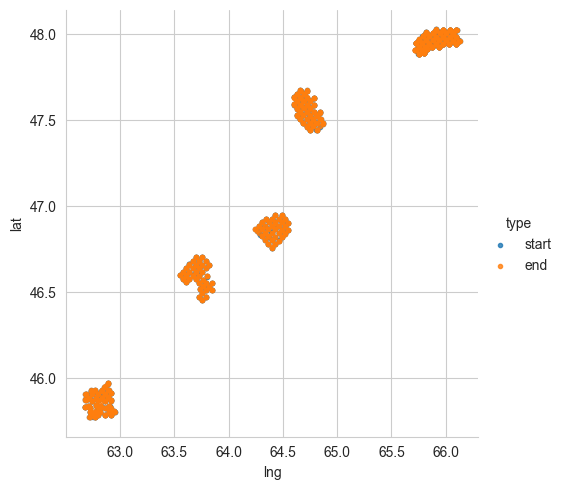

In [61]:

sns.lmplot(data=locs, x="lng", y="lat", fit_reg=False, hue="type", markers=".")